In [1]:
from flash_ansr import FlashANSR, GenerationConfig, install_model, get_path
 
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
MODEL = "ansr-models/v17.0/checkpoint_250000"

In [3]:
nsr = FlashANSR.load(
    directory=get_path('models', MODEL),
    # generation_config=GenerationConfig(method='beam_search', beam_width=128 * 16, equivalence_pruning=True),
    generation_config=GenerationConfig(method='softmax_sampling', choices=1024 * 32),
    parsimony=0.05
).to(device)

In [4]:
trf = nsr.flash_ansr_transformer

In [ ]:
nsr.tokenizer

In [7]:
trf.decoder.tok_embeddings

Embedding(57, 1024)

In [ ]:
# Compute the pairwise similarities between the embeddings
def similarity(embeddings: torch.Tensor) -> torch.Tensor:
    return torch.mm(embeddings, embeddings.t()) / (embeddings.norm(dim=1) * embeddings.norm(dim=1).unsqueeze(1))

In [9]:
similarities = similarity(trf.decoder.tok_embeddings.weight)
print(similarities.shape)

torch.Size([57, 57])


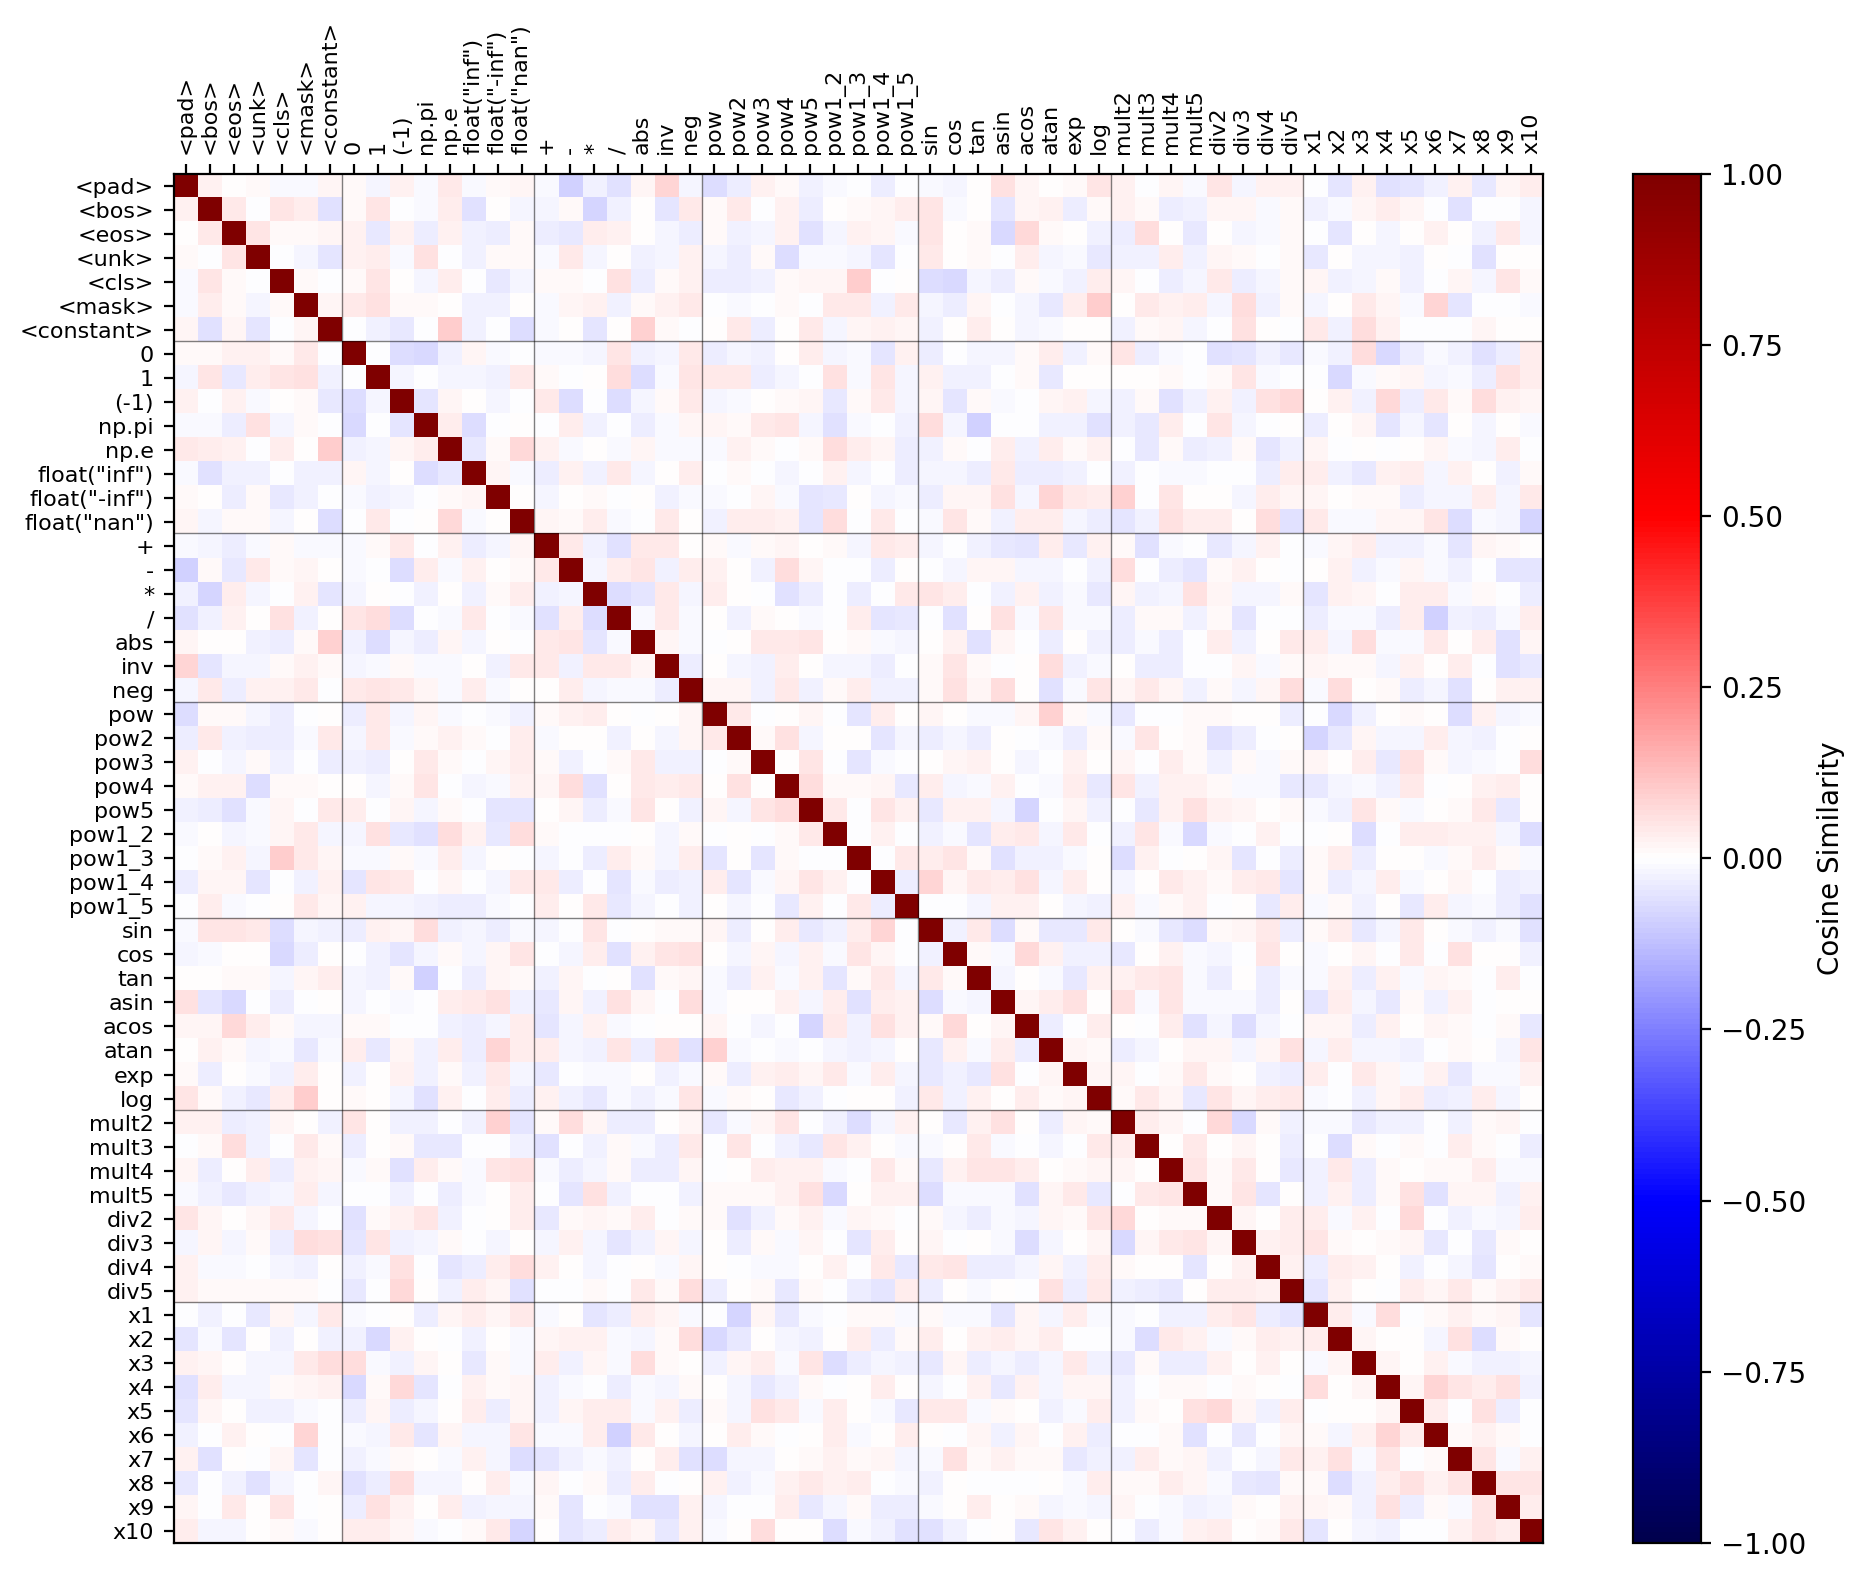

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=200)

im = ax.matshow(similarities.cpu().detach().numpy(), cmap='seismic', vmin=-1, vmax=1, rasterized=True)

ax.set_xticks(np.arange(len(nsr.tokenizer)))
ax.set_yticks(np.arange(len(nsr.tokenizer)))

ax.set_xticklabels(nsr.tokenizer.vocab, rotation=90, fontsize=8)
ax.set_yticklabels(nsr.tokenizer.vocab, fontsize=8)

# Move the xticks to the top
ax.xaxis.set_ticks_position('top')

# Add a colorbar the same height as the image
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Cosine Similarity')

for i in [6, 14, 21, 30, 38, 46]:
    ax.axhline(i + 0.5 - 0.02, color='k', lw=0.5, alpha=0.5)
    ax.axvline(i + 0.5, color='k', lw=0.5, alpha=0.5)

fig.tight_layout()

plt.savefig(get_path('results', 'operator_embeddings', create=True, filename='operator_embeddings.svg'))